In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyentrp.entropy as ent
import statistics
from matplotlib.lines import Line2D

In [ ]:
#  Reading the GTI data of solar farms from the downloaded csv files
# (researchers can download the solar irradiance data for free from Solcast.com)

solarfarm_df = pd.DataFrame()
parameter = 'GtiTracking'

# The longitude and latitude data of solar farms, which are also used to gather the data from Solcast:
solarfarm_df.loc[1, 'lat']= -29.763674
solarfarm_df.loc[1, 'lng']= 151.553617
solarfarm_df.loc[2, 'lat']= -30.961772
solarfarm_df.loc[2, 'lng']= 150.339717
solarfarm_df.loc[3, 'lat']= -33.112985
solarfarm_df.loc[3, 'lng']= 148.076247
solarfarm_df.loc[4, 'lat']= -34.743145
solarfarm_df.loc[4, 'lng']= 145.955613
solarfarm_df.loc[5, 'lat']= -32.150212
solarfarm_df.loc[5, 'lng']= 148.10130
solarfarm_df.loc[6, 'lat']= -32.175425
solarfarm_df.loc[6, 'lng']= 148.6001
solarfarm_df.loc[7, 'lat']= -33.0633359
solarfarm_df.loc[7, 'lng']= 149.0094138
solarfarm_df.loc[8, 'lat']= -35.489885
solarfarm_df.loc[8, 'lng']= 149.143216
solarfarm_df.loc[9, 'lat']= -34.315345
solarfarm_df.loc[9, 'lng']= 146.117528

solarfarm_rawdata_dict = dict()
for ind in solarfarm_df.index:
    solarfarm_rawdata_dict[ind] = pd.read_csv("Input_data/" + str(solarfarm_df.loc[ind, 'lat']) + '_'
                                               + str(solarfarm_df.loc[ind, 'lng']) + "_Solcast_PT5M.csv")
    solarfarm_rawdata_dict[ind].index = solarfarm_rawdata_dict[ind]['PeriodStart']
    solarfarm_rawdata_dict[ind].index = pd.to_datetime(solarfarm_rawdata_dict[ind].index)

In [ ]:
# calculating the average and the WPE of the solar irradiance of solar farms (GTI in our case)

for ind in solarfarm_df.index:
    solarfarm_df.loc[ind, 'avg_of_' + parameter] = sum(solarfarm_rawdata_dict[ind]) / len(solarfarm_rawdata_dict[ind])
    solarfarm_df.loc[ind, 'wpe_of_' + parameter] = ent.weighted_permutation_entropy(
        solarfarm_rawdata_dict[ind].resample('10min').sum(), order=6, delay=1, normalize=True)

#solarfarm_df.to_pickle('solarfarm_df_Fig8and9.pkl')
actual_solarfarm_df = solarfarm_df.loc[[1, 2, 3, 4, 8, 9], :]

In [ ]:
# Reading the pre-generated dataframe of solar farms that includes their lat, lng, the WPE of GTI, and average GTI
# (Created using the past two cells using the solar farms' GTI data)

solarfarm_df = pd.read_pickle('Processed_data/solarfarm_df_Fig8and9.pkl')
actual_solarfarm_df = solarfarm_df.loc[[1, 2, 3, 4, 8, 9], :]
solarfarm_df

In [6]:
# Creating the economical assessment comparison for a hypothetical 51.8MW solar farm

reg_cost = 85600000 # FCAS Regulation cost average in the last 5 years (2018-2022)
# (data available on https://www.aer.gov.au/wholesale-markets/wholesale-statistics/quarterly-global-fcas-costs-by-services)

# Energy market revenue for a 51.8 MW solar farm:
# annaul revenue is assumed to be $10,000 per MW installed capacity of solar farm (reference in the paper)
energy_rev = 5180000

# Ratio of a change in the CPF to a change in the predictability of solar farm generation
# (based on the Figure 7's analysis)
cpf_pred_ratio = -2.72

solarfarm_df.loc[1, 'revenue_offset'] = 0
solarfarm_df.loc[1, 'penalty_offset'] = 0

for i in solarfarm_df.index:
    solarfarm_df.loc[i, 'revenue_offset'] = (solarfarm_df.loc[i, 'avg_of_GtiTracking'] /
                                             solarfarm_df.loc[1, 'avg_of_GtiTracking'] - 1) * 100

    solarfarm_df.loc[i, 'penalty_offset'] = ((solarfarm_df.loc[i, 'wpe_of_GtiTracking'] -
                                        solarfarm_df.loc[1, 'wpe_of_GtiTracking']) * reg_cost * cpf_pred_ratio) / energy_rev

    solarfarm_df.loc[i, 'overall_offset'] = solarfarm_df.loc[i, 'penalty_offset'] + solarfarm_df.loc[i, 'revenue_offset']

C:\Users\a1792406\AppData\Local\Temp/ipykernel_18880/1158552062.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.bar(list(solarfarm_df[1:].index - 0.16), solarfarm_df['revenue_offset'][1:], width=0.3, color='darkorange', align='center')
C:\Users\a1792406\AppData\Local\Temp/ipykernel_18880/1158552062.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.bar(list(solarfarm_df[1:].index + 0.16), solarfarm_df['overall_offset'][1:], width=0.3, color='darkcyan', align='center'

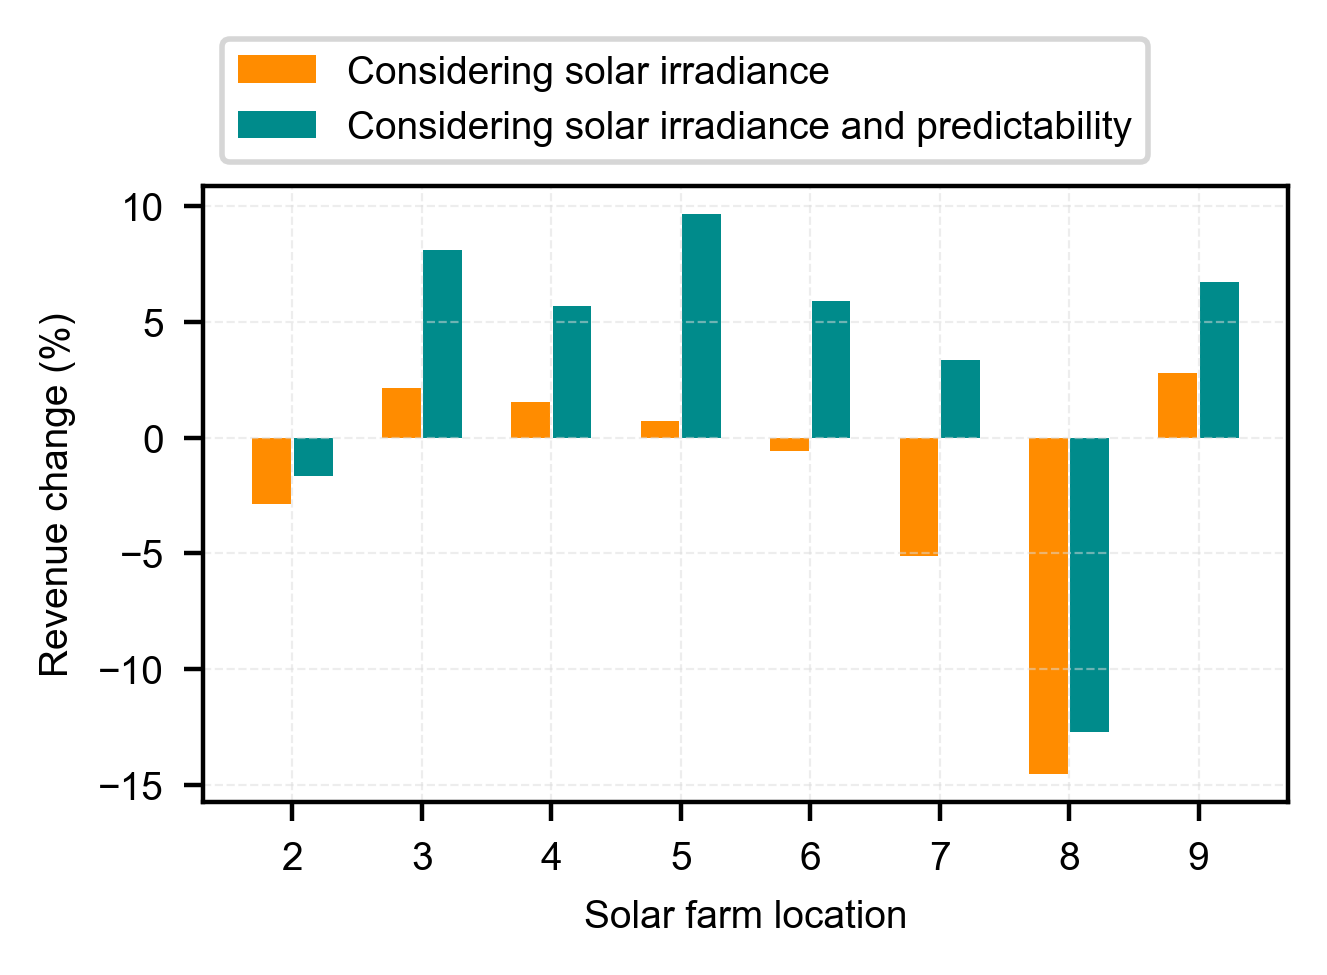

In [7]:
plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 7
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

plt.figure(figsize=(3.5, 2))

ax = plt.subplot(111)
ax.bar(list(solarfarm_df[1:].index - 0.16), solarfarm_df['revenue_offset'][1:], width=0.3, color='darkorange', align='center')
ax.bar(list(solarfarm_df[1:].index + 0.16), solarfarm_df['overall_offset'][1:], width=0.3, color='darkcyan', align='center')

plt.xlabel('Solar farm location')
plt.ylabel('Revenue change (%)')
plt.grid(color = 'gainsboro', linestyle = '--', linewidth = 0.4, alpha = 0.5)
plt.locator_params(axis='x', nbins=9)

ax.axes.xaxis.set_ticklabels([1,2,3,4,5,6,7,8,9])
ax.legend(["Considering solar irradiance", "Considering solar irradiance and predictability"],
          loc =2, bbox_to_anchor=(0, 1.27))

plt.savefig('Figure9.pdf', dpi = 400, bbox_inches='tight')

C:\Users\a1792406\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=144.0,-36.0,154.2,-29.500000000000004&bboxSR=4326&imageSR=4326&size=1600,1019&dpi=96&format=png32&transparent=true&f=image


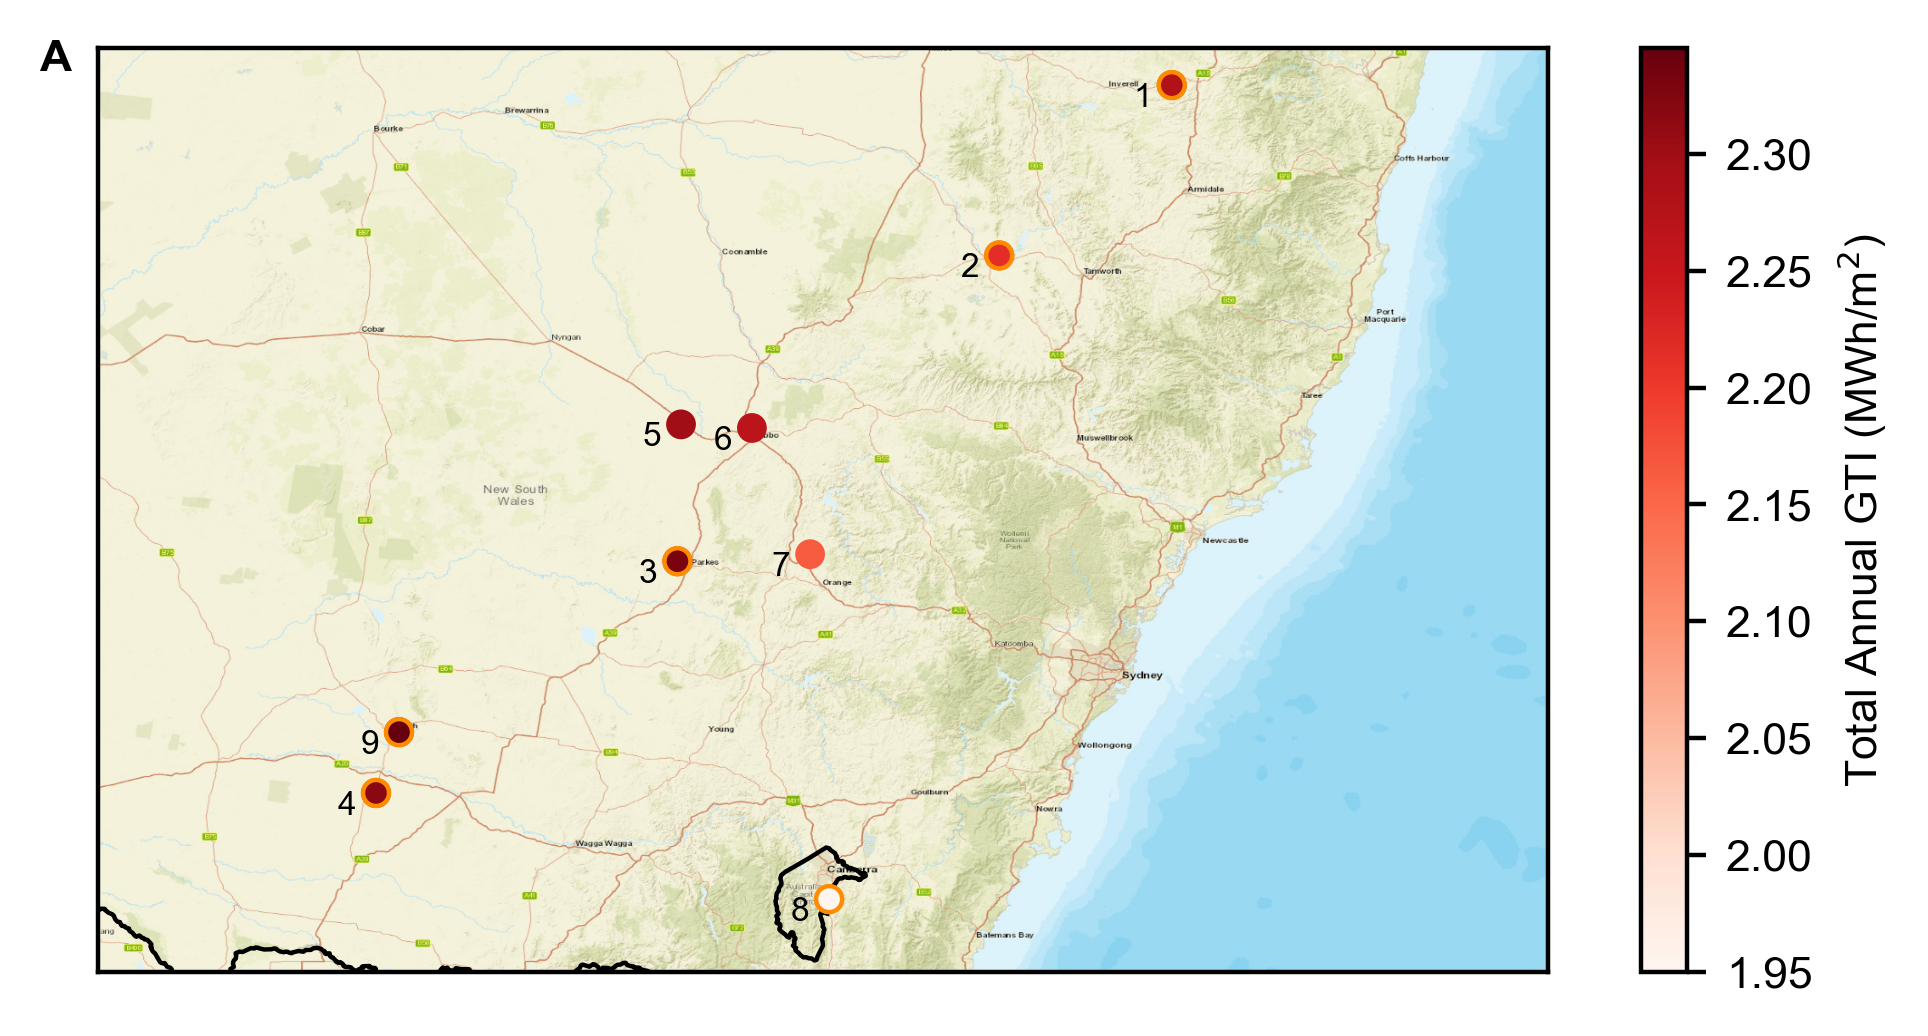

In [15]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

fig = plt.figure()
ax  = fig.add_subplot(111)
fig.set_size_inches(6, 3)

m = Basemap(projection='cyl', resolution='h', llcrnrlat=-36, urcrnrlat=-29.5, llcrnrlon=144, urcrnrlon=154.2)

# Writing the name of states and cities:
for i in solarfarm_df.index:
    plt.text(solarfarm_df.loc[i, 'lng'] - 0.27, solarfarm_df.loc[i, 'lat'] - 0.2, str(i), fontsize=6,
             ha='left', va='bottom', color='black')

m.arcgisimage(service='World_Street_Map', xpixels = 1600, verbose= True)
m.drawstates(linewidth = 0.8)

lat = solarfarm_df['lat'].tolist()
lng = solarfarm_df['lng'].tolist()
scolor = [i * 8760 / 1000000 for i in solarfarm_df['avg_of_GtiTracking'].tolist()]

m.scatter(lng, lat, latlon=True, c=scolor, s=19, cmap='Reds', alpha = 1, zorder = 4)

cbar =  plt.colorbar()
plt.clim(min(solarfarm_df['avg_of_GtiTracking']) * 8760 / 1000000, max(solarfarm_df['avg_of_GtiTracking']) * 8760 / 1000000)
cbar.set_label('Total Annual GTI (MWh/m$^2$)')

m.scatter(actual_solarfarm_df['lng'], actual_solarfarm_df["lat"], s=22, facecolors='none', edgecolors='darkorange', zorder = 5, linewidth= 0.8)

# for captions:
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 - data_width * 0.04 , ymax - data_height * 0.025,'A', weight='bold')

plt.savefig("Figure8A.pdf", dpi=400,bbox_inches='tight')

C:\Users\a1792406\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=144.0,-36.0,154.2,-29.500000000000004&bboxSR=4326&imageSR=4326&size=1600,1019&dpi=96&format=png32&transparent=true&f=image


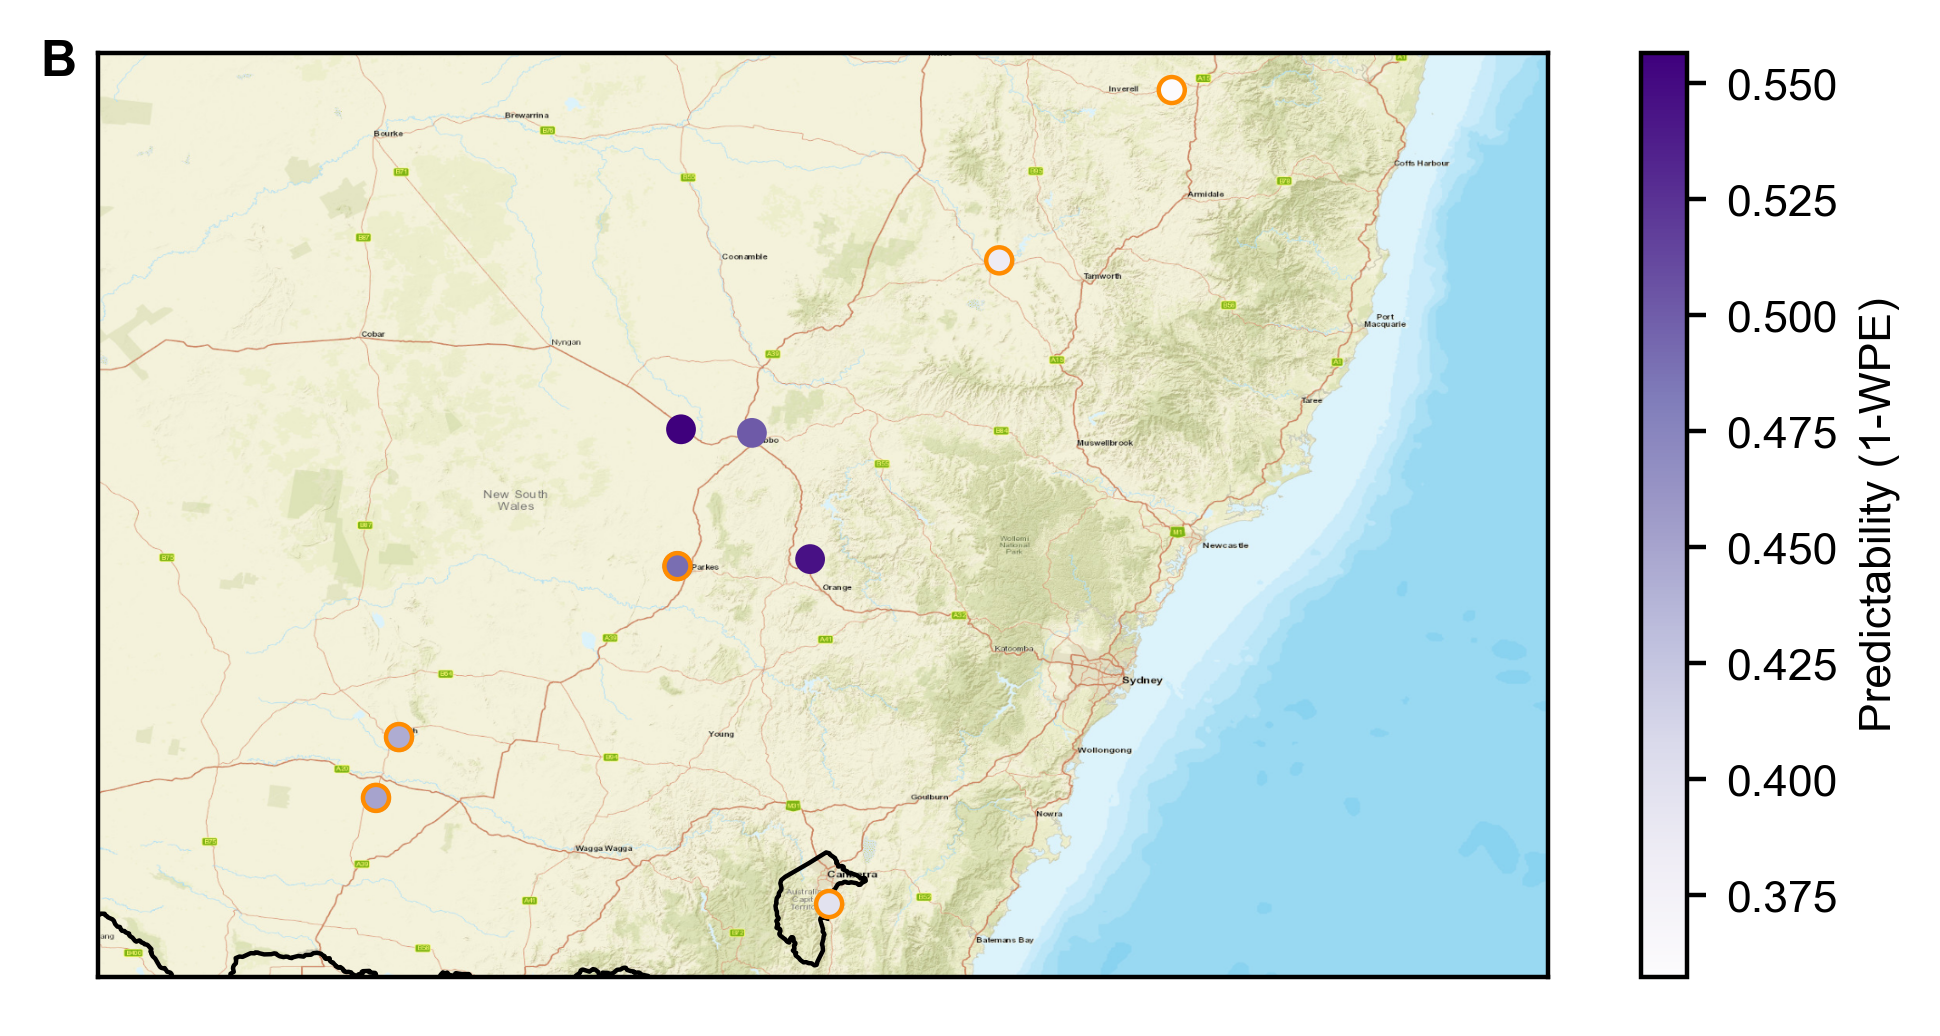

In [16]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

fig = plt.figure()
ax  = fig.add_subplot(111)
fig.set_size_inches(6, 3)

m = Basemap(projection='cyl', resolution='h', llcrnrlat=-36, urcrnrlat=-29.5, llcrnrlon=144, urcrnrlon=154.2)

m.arcgisimage(service='World_Street_Map', xpixels = 1600, verbose= True)

m.drawstates(linewidth = 0.8)

lat = solarfarm_df['lat'].tolist()
lng = solarfarm_df['lng'].tolist()
scolor = [1 - i for i in solarfarm_df['wpe_of_GtiTracking'].tolist()]

m.scatter(lng, lat, latlon=True, c=scolor, s=19, cmap='Purples', alpha = 1, zorder = 4)

cbar =  plt.colorbar()
plt.clim(1 - max(solarfarm_df['wpe_of_GtiTracking']), 1 - min(solarfarm_df['wpe_of_GtiTracking']))
cbar.set_label('Predictability (1-WPE)')

m.scatter(actual_solarfarm_df['lng'], actual_solarfarm_df["lat"], s=22, facecolors='none', edgecolors='darkorange', zorder = 5, linewidth= 0.8)

# for captions:
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 - data_width * 0.04 , ymax - data_height * 0.025,'B', weight='bold',  fontsize=9)

plt.savefig("Figure8B.pdf", dpi=400,bbox_inches='tight')